In [8]:
import numpy as np
import pandas as pd
import geopandas as gp
import pysal as ps
import matplotlib
import matplotlib.pyplot as plt
%pylab inline
from sel_bw import Sel_BW
from gwr import GWR
from pysal.contrib.glm.family import Gaussian

Populating the interactive namespace from numpy and matplotlib


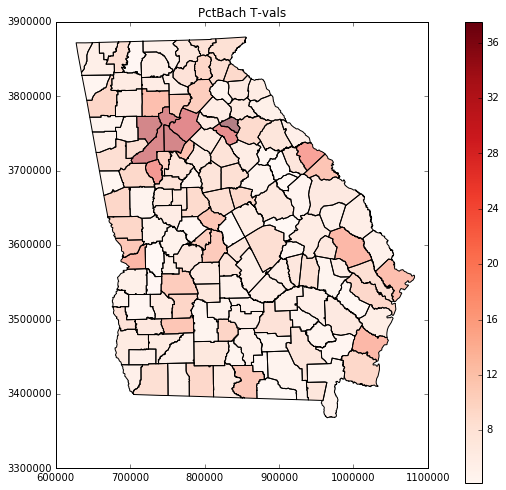

In [45]:
#Data

data = ps.open(ps.examples.get_path('GData_utm.csv'))
shp = gp.read_file('/Users/toshan/dev/pysal/pysal/examples/georgia/G_utm.shp')
vmin, vmax = np.min(shp['PctBach']), np.max(shp['PctBach']) 
ax = shp.plot('PctBach', vmin=vmin, vmax=vmax, figsize=(8,8), cmap='Reds')
ax.set_title('PctBach' + ' T-vals')
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap='Reds')
sm._A = []
fig.colorbar(sm, cax=cax)


In [34]:
# Prep data into design matrix and coordinates

#Dependent variable
y = shp.PctBach.reshape((-1,1))

#Design matrix - covariates - intercept added automatically
pov = shp.PctPov.reshape((-1,1))
rural = shp.PctRural.reshape((-1,1))
blk = shp.PctBlack.reshape((-1,1))
X = np.hstack([pov, rural, blk])
labels = ['Intercept', 'PctPov', 'PctRural', 'PctAfricanAmer']

#Coordinates for calibration points
u = shp.X
v = shp.Y
coords = zip(u,v)

In [35]:
#Find optimal bandwidth using golden section search to minimize AICc

#Instantiate bandwidth selection class - bisquare NN (adaptive)
bw = Sel_BW(coords, y, X, kernel='bisquare', fixed=False)

#Find optimal bandwidth by minimizing AICc using golden section search algorithm
bw = bw.search(search='golden_section', criterion='AICc')
print bw

100.0


In [36]:
#Instantiate GWR model and then estimate parameters and diagnostics using fit method
model = GWR(coords, y, X, bw, family=Gaussian(), fixed=False, kernel='bisquare')
results = model.fit()

In [37]:
#Results in a set of mappable results 
results.params.shape

(172, 4)

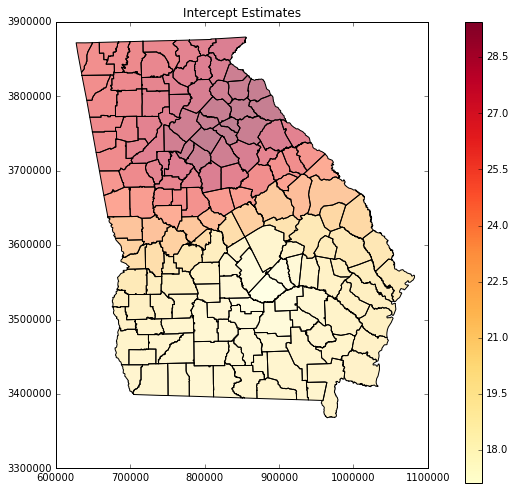

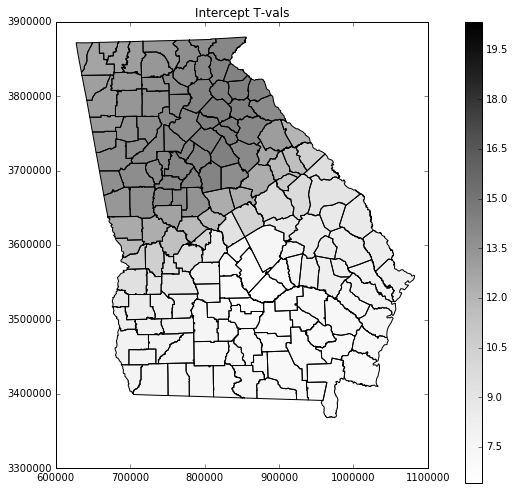

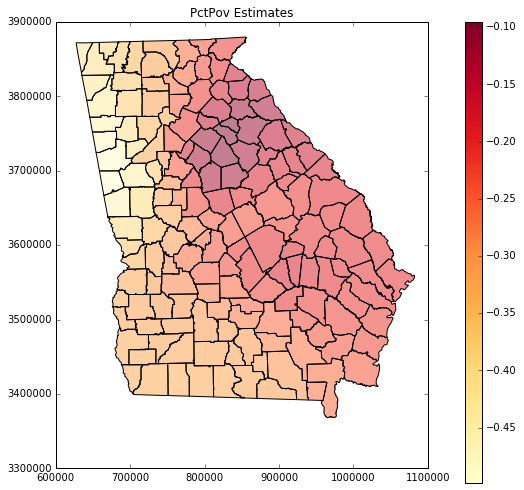

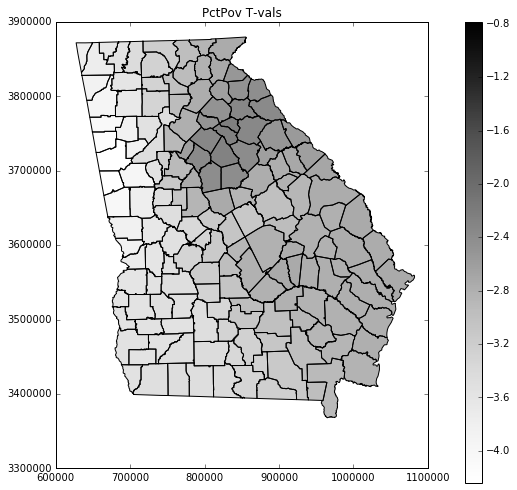

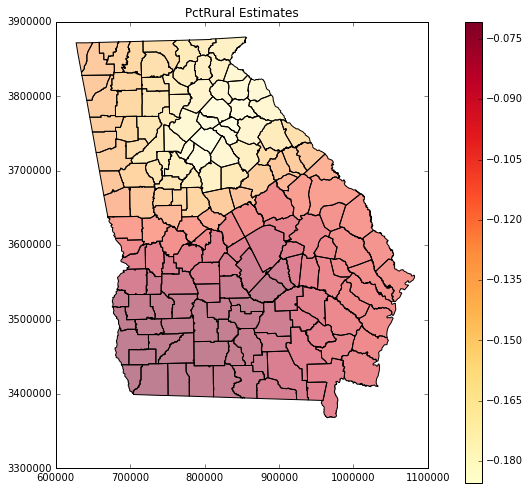

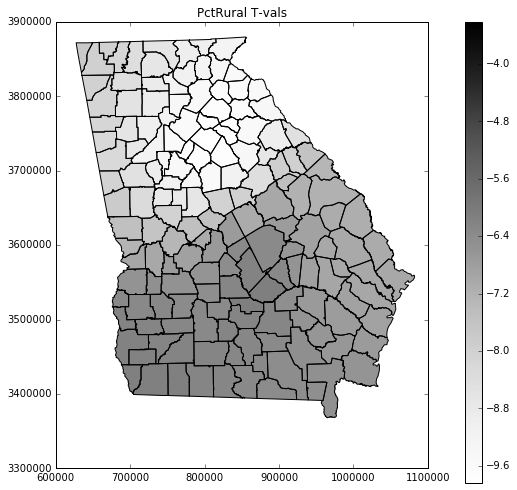

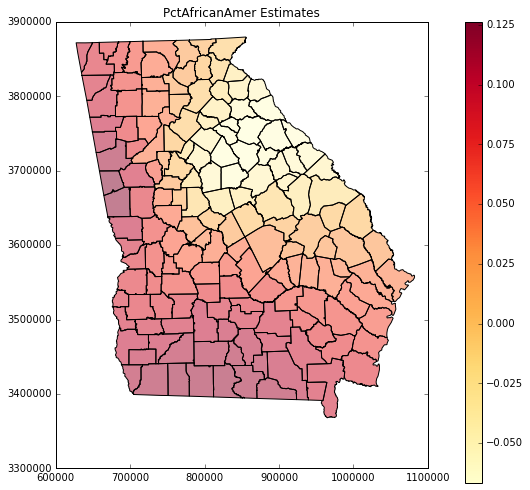

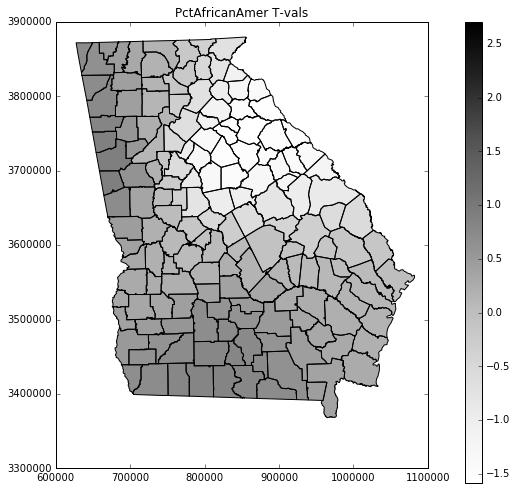

In [38]:
#Map Parameter estimates and T-vals for each covariate


for param in range(results.params.shape[1]):
    shp[str(param)] = results.params[:,param]
    vmin, vmax = np.min(shp[str(param)]), np.max(shp[str(param)]) 
    ax = shp.plot(str(param), vmin=vmin, vmax=vmax, figsize=(8,8), cmap='YlOrRd')
    ax.set_title(labels[param] + ' Estimates')
    fig = ax.get_figure()
    cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
    sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap='YlOrRd')
    sm._A = []
    fig.colorbar(sm, cax=cax)
    
    shp[str(param)] = results.tvalues[:,param]
    vmin, vmax = np.min(shp[str(param)]), np.max(shp[str(param)]) 
    ax = shp.plot(str(param), vmin=vmin, vmax=vmax, figsize=(8,8), cmap='Greys')
    ax.set_title(labels[param] + ' T-vals')
    fig = ax.get_figure()
    cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
    sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap='Greys')
    sm._A = []
    fig.colorbar(sm, cax=cax)




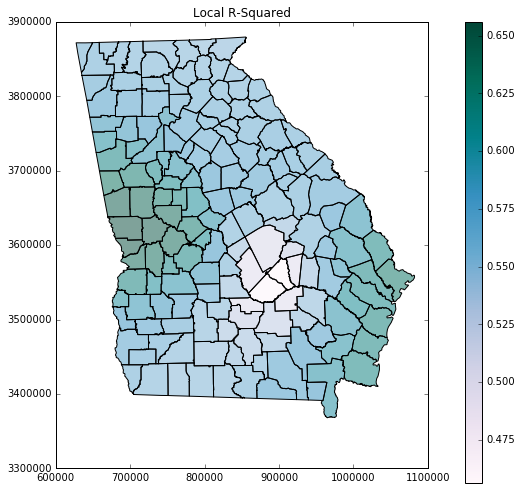

In [39]:
#Map local R-square values which is a weighted R-square at each observation location

shp['localR2'] = results.localR2
vmin, vmax = np.min(shp['localR2']), np.max(shp['localR2']) 
ax = shp.plot('localR2', vmin=vmin, vmax=vmax, figsize=(8,8), cmap='PuBuGn')
ax.set_title('Local R-Squared')
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap='PuBuGn')
sm._A = []
fig.colorbar(sm, cax=cax)

